31個のステロイド骨格の化合物に対してQSARを行なってみる。

In [1]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit import rdBase
from rdkit.Chem import Descriptors, Draw
from rdkit.ML.Descriptors import MoleculeDescriptors

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_score, KFold


%matplotlib inline

print(sys.version_info)
print(f'RDKit version is {rdBase.rdkitVersion}')
print(f'scikit learn versoin is {sklearn.__version__}')

sys.version_info(major=3, minor=6, micro=2, releaselevel='final', serial=0)
RDKit version is 2017.09.1
scikit learn versoin is 0.19.1


### 1. Steroid化合物データの読み込み

steroid.smiファイルを読み込む。これには31個のステロイド骨格の化合物の名前、SMILESキー、活性の情報が含まれている。

In [2]:
!head -n 5 steroid.smi

SMILES NAME ACTIVITY
C[C@]12CCC(=O)C=C1CC[C@@H]3[C@@H]2[C@H](C[C@]4([C@H]3CC[C@@H]4C(=O)CO)C=O)O aldosterone 6.279
C[C@]12CC[C@H](C[C@@H]1CC[C@@H]3[C@@H]2CC[C@]4([C@H]3CCC4O)C)O androstanediol 5.000
C[C@]12CC[C@H]3[C@H]([C@@H]1CC[C@@H]2O)CC=C4[C@@]3(CC[C@@H](C4)O)C androstenediol 5.000
C[C@]12CCC(=O)C=C1CC[C@@H]3[C@@H]2CC[C@]4([C@H]3CCC4=O)C androstenedione 5.763


化合物の名前を読み込んでnamesという変数に代入しておく。

In [3]:
names = !awk '{print $2}' steroid.smi
names = names[1:]
names[:5]

['aldosterone',
 'androstanediol',
 'androstenediol',
 'androstenedione',
 'androsterone']

化合物の活性を読み込んでactivitiesという変数に代入しておく。

In [4]:
activities = !awk '{print $3}' steroid.smi
activities = list(map(float, activities[1:]))
activities[:5]

[6.279, 5.0, 5.0, 5.763, 5.613]

化学構造を読み込んでグラフ構造データとしてmolsという変数に代入しておく。

In [5]:
mols = [mol for mol in Chem.SmilesMolSupplier('steroid.smi')]

In [6]:
len(mols)

31

二次元構造を表示してみる。

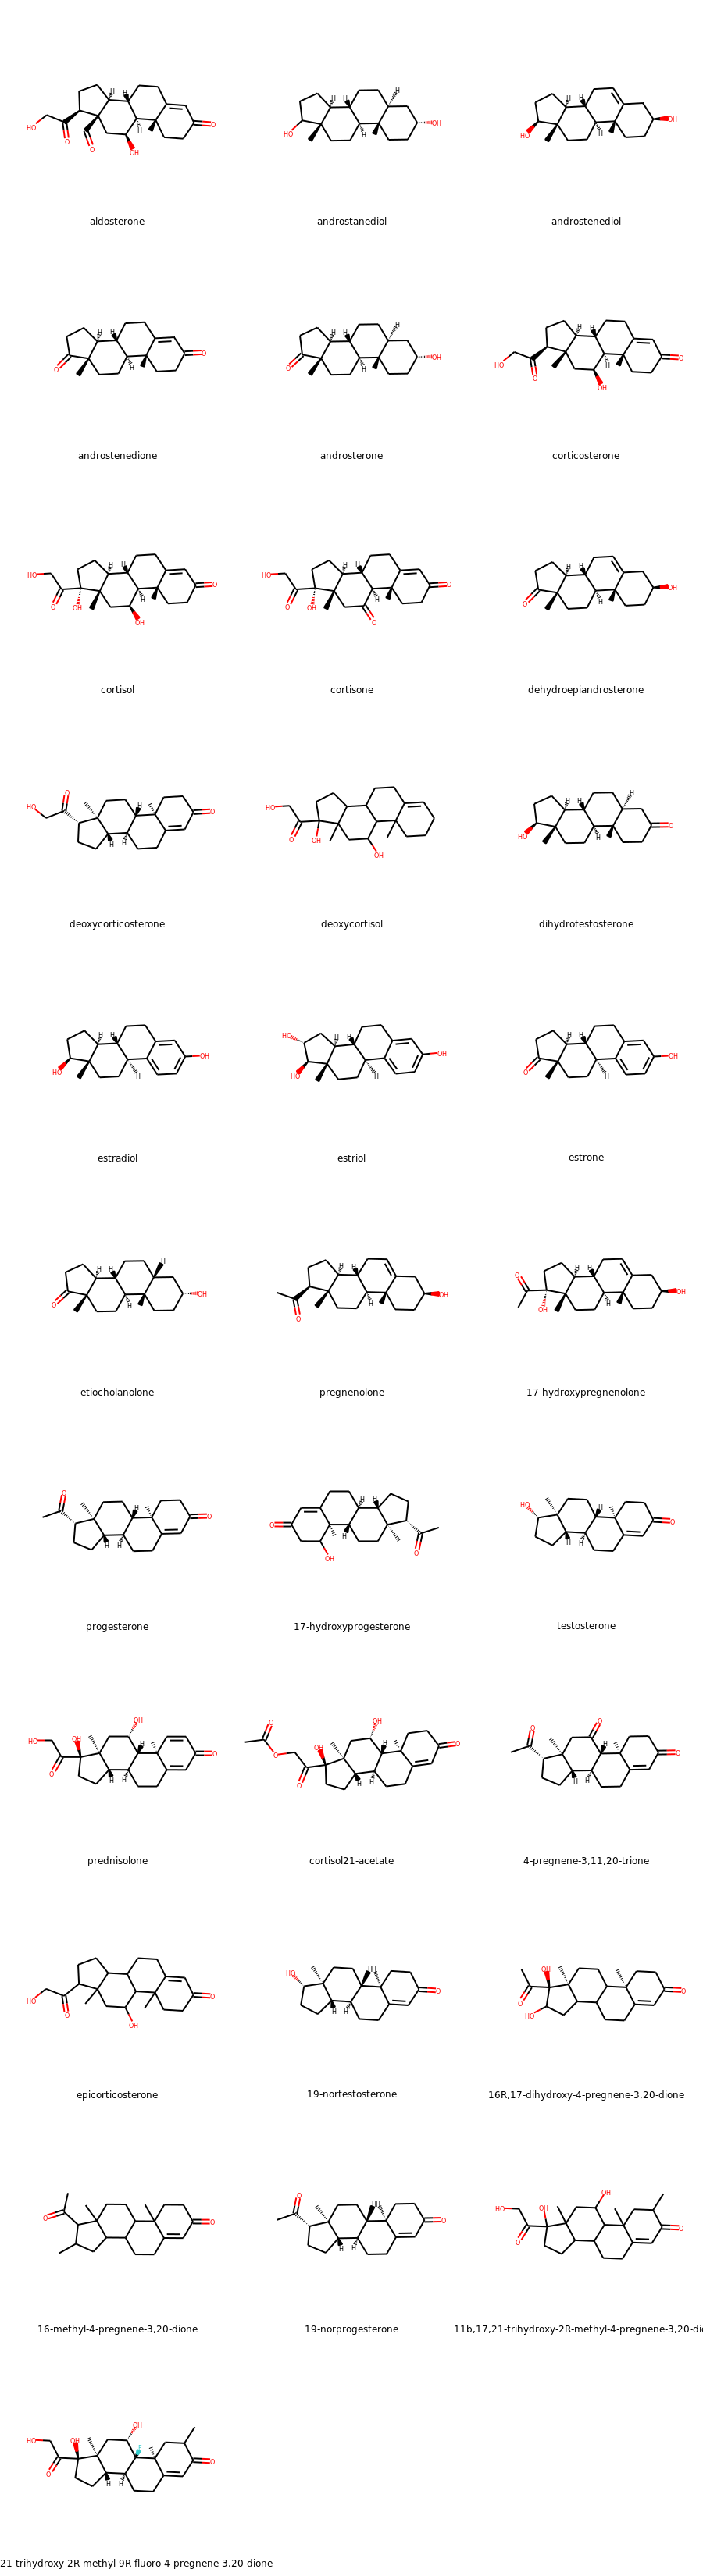

In [7]:
Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(300, 300), legends=names)

### 2. 構造記述子計算

今回はRDKit (version 2017.09.1) で計算可能な200個の記述子すべてを計算する。

In [8]:
descriptor_names = [x[0] for x in Descriptors._descList]
descriptor_names[:5]

['MaxEStateIndex',
 'MinEStateIndex',
 'MaxAbsEStateIndex',
 'MinAbsEStateIndex',
 'qed']

In [9]:
calc = MoleculeDescriptors.MolecularDescriptorCalculator(descriptor_names)
descs = [calc.CalcDescriptors(mol) for mol in mols]

最後に機械学習で用いるためにデータフレームに変換しておく。

In [10]:
descs = pd.DataFrame(descs, columns=descriptor_names)
descs.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,12.289812,-0.830892,12.289812,0.038568,0.749582,360.450,332.226,360.193674,142,0,...,0,0,0,0,0,0,0,0,0,0
1,10.472190,-0.053558,10.472190,0.040015,0.713622,292.463,260.207,292.240230,120,0,...,0,0,0,0,0,0,0,0,0,0
2,10.456777,-0.108302,10.456777,0.074249,0.668278,290.447,260.207,290.224580,118,0,...,0,0,0,0,0,0,0,0,0,0
3,12.354302,-0.024573,12.354302,0.024573,0.671938,286.415,260.207,286.193280,114,0,...,0,0,0,0,0,0,0,0,0,0
4,12.377281,-0.054130,12.377281,0.012444,0.732973,290.447,260.207,290.224580,118,0,...,0,0,0,0,0,0,0,0,0,0


これらのデータを説明変数として、activitiesを目的変数として機械学習を行っていく。

### 3. 前処理

#### 3.1 分散が0のデータを取り除く

In [11]:
descs = descs.loc[:, descs.std(ddof=1) != 0]
descs.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,MaxPartialCharge,...,fr_allylic_oxid,fr_aryl_methyl,fr_benzene,fr_ester,fr_ether,fr_halogen,fr_ketone,fr_ketone_Topliss,fr_phenol,fr_phenol_noOrthoHbond
0,12.289812,-0.830892,12.289812,0.038568,0.749582,360.450,332.226,360.193674,142,0.161744,...,1,0,0,0,0,0,2,1,0,0
1,10.472190,-0.053558,10.472190,0.040015,0.713622,292.463,260.207,292.240230,120,0.059619,...,0,0,0,0,0,0,0,0,0,0
2,10.456777,-0.108302,10.456777,0.074249,0.668278,290.447,260.207,290.224580,118,0.059619,...,1,0,0,0,0,0,0,0,0,0
3,12.354302,-0.024573,12.354302,0.024573,0.671938,286.415,260.207,286.193280,114,0.155197,...,1,0,0,0,0,0,2,1,0,0
4,12.377281,-0.054130,12.377281,0.012444,0.732973,290.447,260.207,290.224580,118,0.138555,...,0,0,0,0,0,0,1,1,0,0


200個あった記述子が198個まで減ったので分散が0のカラムが92個あったことになる

#### 3.2 オートスケーリング

説明変数descsのオートスケーリングを行う。

In [12]:
descs = (descs - descs.mean()) / descs.std(ddof=1)
descs.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,MaxPartialCharge,...,fr_allylic_oxid,fr_aryl_methyl,fr_benzene,fr_ester,fr_ether,fr_halogen,fr_ketone,fr_ketone_Topliss,fr_phenol,fr_phenol_noOrthoHbond
0,0.052249,-0.394060,0.052249,-0.558107,0.464983,1.009496,1.079454,1.009584,0.912786,0.145284,...,0.169021,-0.322004,-0.322004,-0.179605,-0.179605,-0.179605,0.636245,0.258342,-0.322004,-0.322004
1,-1.542554,0.732122,-1.542554,-0.535215,-0.318030,-0.821608,-0.933544,-0.821556,-0.635771,-2.292436,...,-1.140890,-0.322004,-0.322004,-0.179605,-0.179605,-0.179605,-1.829203,-1.743812,-0.322004,-0.322004
2,-1.556077,0.652810,-1.556077,0.006553,-1.305375,-0.875905,-0.933544,-0.875872,-0.776549,-2.292431,...,0.169021,-0.322004,-0.322004,-0.179605,-0.179605,-0.179605,-1.829203,-1.743812,-0.322004,-0.322004
3,0.108834,0.774114,0.108834,-0.779583,-1.225677,-0.984500,-0.933544,-0.984503,-1.058105,-0.010978,...,0.169021,-0.322004,-0.322004,-0.179605,-0.179605,-0.179605,0.636245,0.258342,-0.322004,-0.322004
4,0.128996,0.731293,0.128996,-0.971518,0.103326,-0.875905,-0.933544,-0.875872,-0.776549,-0.408225,...,-1.140890,-0.322004,-0.322004,-0.179605,-0.179605,-0.179605,-0.596479,0.258342,-0.322004,-0.322004


#### 3.3 目的変数

目的変数activitiesのオートスケーリングを行う。最後に、扱いやすいように変数yに代入しておく。

In [13]:
activities = np.array(activities)
y = (activities - activities.mean()) / activities.std()
y[:5]

array([-0.10089286, -1.30435279, -1.30435279, -0.58641696, -0.72755768])

### 4. 記述子選択

multicollinearityいわゆる多重共線性のある記述子のどちらかを自動で取り除くためのクラスや関数は  
残念ながらscikit-learnにはないので今回は以下のように自分でスクリプトを書いてみた。

#### 4.1 説明変数と目的変数を含めたデータフレームの相関行列を計算する


一時的に説明変数descsと目的変数yを結合させたデータフレームtmpを作成する。

In [14]:
tmp = pd.concat([descs, pd.DataFrame(y, columns=['activity'])], axis=1)
tmp.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,MaxPartialCharge,...,fr_aryl_methyl,fr_benzene,fr_ester,fr_ether,fr_halogen,fr_ketone,fr_ketone_Topliss,fr_phenol,fr_phenol_noOrthoHbond,activity
0,0.052249,-0.394060,0.052249,-0.558107,0.464983,1.009496,1.079454,1.009584,0.912786,0.145284,...,-0.322004,-0.322004,-0.179605,-0.179605,-0.179605,0.636245,0.258342,-0.322004,-0.322004,-0.100893
1,-1.542554,0.732122,-1.542554,-0.535215,-0.318030,-0.821608,-0.933544,-0.821556,-0.635771,-2.292436,...,-0.322004,-0.322004,-0.179605,-0.179605,-0.179605,-1.829203,-1.743812,-0.322004,-0.322004,-1.304353
2,-1.556077,0.652810,-1.556077,0.006553,-1.305375,-0.875905,-0.933544,-0.875872,-0.776549,-2.292431,...,-0.322004,-0.322004,-0.179605,-0.179605,-0.179605,-1.829203,-1.743812,-0.322004,-0.322004,-1.304353
3,0.108834,0.774114,0.108834,-0.779583,-1.225677,-0.984500,-0.933544,-0.984503,-1.058105,-0.010978,...,-0.322004,-0.322004,-0.179605,-0.179605,-0.179605,0.636245,0.258342,-0.322004,-0.322004,-0.586417
4,0.128996,0.731293,0.128996,-0.971518,0.103326,-0.875905,-0.933544,-0.875872,-0.776549,-0.408225,...,-0.322004,-0.322004,-0.179605,-0.179605,-0.179605,-0.596479,0.258342,-0.322004,-0.322004,-0.727558


DataFrameクラスの`corr`メソッドを用いるとデータフレームの相関行列を計算することができる。

In [15]:
corrs = tmp.corr()
corrs.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,MaxPartialCharge,...,fr_aryl_methyl,fr_benzene,fr_ester,fr_ether,fr_halogen,fr_ketone,fr_ketone_Topliss,fr_phenol,fr_phenol_noOrthoHbond,activity
MaxEStateIndex,1.000000,-0.479977,1.000000,-0.176513,-0.075457,0.609761,0.613620,0.609772,0.598414,0.560143,...,-0.356696,-0.356696,0.104182,0.104182,0.769635,0.629679,0.607731,-0.356696,-0.356696,0.254157
MinEStateIndex,-0.479977,1.000000,-0.479977,0.370516,0.134476,-0.819847,-0.829519,-0.819897,-0.807497,-0.625478,...,0.159263,0.159263,-0.275820,-0.275820,-0.360348,-0.348206,-0.290492,0.159263,0.159263,-0.357632
MaxAbsEStateIndex,1.000000,-0.479977,1.000000,-0.176513,-0.075457,0.609761,0.613620,0.609772,0.598414,0.560143,...,-0.356696,-0.356696,0.104182,0.104182,0.769635,0.629679,0.607731,-0.356696,-0.356696,0.254157
MinAbsEStateIndex,-0.176513,0.370516,-0.176513,1.000000,-0.067012,-0.133302,-0.140264,-0.133372,-0.132663,-0.082260,...,0.026305,0.026305,-0.095577,-0.095577,-0.153094,0.117712,-0.018472,0.026305,0.026305,0.217391
qed,-0.075457,0.134476,-0.075457,-0.067012,1.000000,-0.033651,-0.022474,-0.033662,-0.051235,-0.006671,...,0.091289,0.091289,-0.111957,-0.111957,-0.247764,0.243277,0.199396,0.091289,0.091289,0.200986


特に注目したいactivityとの相関のみを抽出してみる。  
この時、データフレームが省略されると見にくいので一時的に200行まで表示されるようにする。

In [16]:
pd.set_option('display.max_rows', 200)

In [17]:
corrs['activity']

MaxEStateIndex             0.254157
MinEStateIndex            -0.357632
MaxAbsEStateIndex          0.254157
MinAbsEStateIndex          0.217391
qed                        0.200986
MolWt                      0.628273
HeavyAtomMolWt             0.626297
ExactMolWt                 0.628236
NumValenceElectrons        0.622837
MaxPartialCharge           0.632899
MinPartialCharge           0.337435
MaxAbsPartialCharge       -0.337435
MinAbsPartialCharge        0.632899
FpDensityMorgan1           0.485674
FpDensityMorgan2           0.383606
FpDensityMorgan3           0.083557
BalabanJ                   0.190775
BertzCT                    0.589982
Chi0                       0.634322
Chi0n                      0.641281
Chi0v                      0.641281
Chi1                       0.656568
Chi1n                      0.629669
Chi1v                      0.629669
Chi2n                      0.542026
Chi2v                      0.542026
Chi3n                      0.480019
Chi3v                      0

名前が似ているものなどは説明変数同士で相関が高く、多重共線性(multicolinarity)がある場合があるので注意する。  
例えば以下の例では非常に相関が高いのが確認できる。このような場合、同時に用いると機械学習の種類によっては正常に処理が行われないことがある。

In [18]:
corrs.loc[['Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n'], ['Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n']]

,Chi0,Chi0n,Chi0v,Chi1,Chi1n
Chi0,1.000000,0.961583,0.961583,0.995734,0.906584
Chi0n,0.961583,1.000000,1.000000,0.950261,0.980248
Chi0v,0.961583,1.000000,1.000000,0.950261,0.980248
Chi1,0.995734,0.950261,0.950261,1.000000,0.897744
Chi1n,0.906584,0.980248,0.980248,0.897744,1.000000


In [19]:
corrs.loc[['fr_C_O', 'fr_ketone'], ['fr_C_O', 'fr_ketone']]

,fr_C_O,fr_ketone
fr_C_O,1.000000,0.960864
fr_ketone,0.960864,1.000000


今回はactivityと相関が高い以下のものを選んだ。  

| name  | correlation |
|:-------:|:---------------:|
| MolWt | 0.628273 |
| MolLogP | -0.350909 |
| fr_Ar_OH | -0.426950 |
| fr_ketone | 0.686900 |


説明変数間の相関係数は以下のようになっている。

In [20]:
corrs.loc[['MolWt', 'MolLogP', 'fr_Ar_OH', 'fr_ketone', 'activity'], ['MolWt', 'MolLogP', 'fr_Ar_OH', 'fr_ketone', 'activity']]

,MolWt,MolLogP,fr_Ar_OH,fr_ketone,activity
MolWt,1.000000,-0.691603,-0.411515,0.640335,0.628273
MolLogP,-0.691603,1.000000,0.009991,-0.266340,-0.350909
fr_Ar_OH,-0.411515,0.009991,1.000000,-0.471920,-0.426950
fr_ketone,0.640335,-0.266340,-0.471920,1.000000,0.686900
activity,0.628273,-0.350909,-0.426950,0.686900,1.000000


説明変数 MolWt, MolLogP, fr_Ar_OH, fr_ketone のみを変数Xに代入する。一度全サンプルのデータを確認してみる。

In [21]:
X = descs.loc[:, ['MolWt', 'MolLogP', 'fr_Ar_OH', 'fr_ketone']]
X

,MolWt,MolLogP,fr_Ar_OH,fr_ketone
0,1.009496,-1.551973,-0.322004,0.636245
1,-0.821608,0.471091,-0.322004,-1.829203
2,-0.875905,0.386248,-0.322004,-1.829203
3,-0.984500,0.828408,-0.322004,0.636245
4,-0.875905,0.692171,-0.322004,-0.596479
5,0.632890,-0.680182,-0.322004,0.636245
6,1.063793,-1.620038,-0.322004,0.636245
7,1.009496,-1.398958,-0.322004,1.868968
8,-0.930202,0.607328,-0.322004,-0.596479
9,0.201986,0.412688,-0.322004,0.636245


説明変数同士および説明変数と目的変数の間の散布を書いてみる。

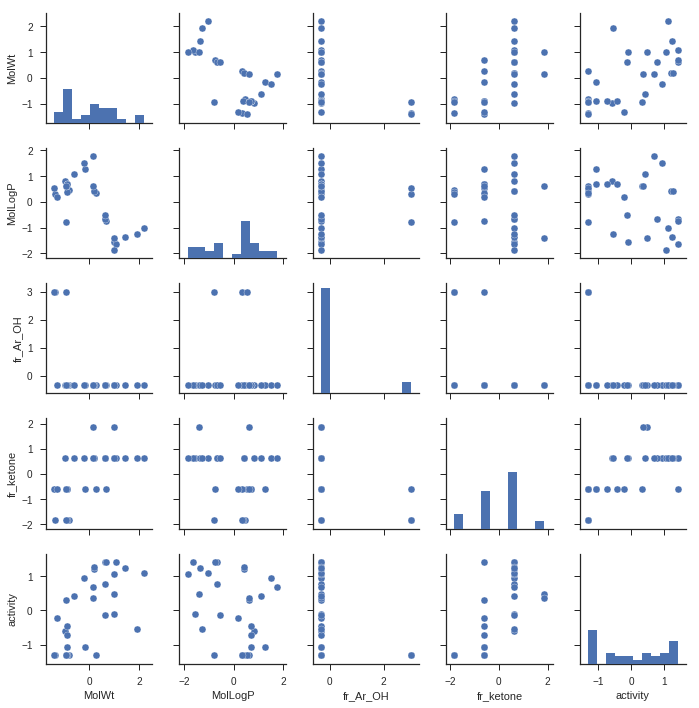

In [22]:
import seaborn as sns
sns.set(style="ticks", color_codes=True)
sns.pairplot(pd.concat([X, pd.DataFrame(y, columns=['activity'])], axis=1), size=2.0)

説明変数X, 目的変数yこれらのデータを用いて機械学習を行なってみる。  
最後にデータフレームで表示される行数を戻しておく。

In [23]:
pd.set_option('display.max_rows', 101)

### 5. 機械学習

#### 5.1.1 重回帰分析

重回帰分析を行なってみる。

In [24]:
regr = LinearRegression()
regr.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

説明変数`MolWt`, `MolLogP`, `fr_Ar_OH`, `fr_ketone`の各係数の重みは`regr.coef_` に保存されている。

In [25]:
regr.coef_

array([ 0.26000013, -0.05108741, -0.10545869,  0.46839306])

切片は`intercept_`に保存されている。

In [26]:
regr.intercept_

1.0428142573123469e-15

これらより今回得られたモデル式は  
`activity = 0.260 × MolWt - 0.051 ×　MolLogP - 0.105 × fr_Ar_OH + 0.468 × fr_ketone`  
であると言える。

予測値は`predict`メソッドを用いて求めることができる。

In [27]:
predicted_value = regr.predict(X)
predicted_value

array([ 0.67372609, -1.06051286, -1.07029574,  0.03367936, -0.50852531,
        0.53127088,  0.69132067,  1.24330822, -0.51830819,  0.36340398,
       -0.02853379, -0.50852531, -1.54430427, -1.37643737, -0.99231672,
       -0.50852531, -0.35636368, -0.1963139 ,  0.19562387,  0.36349077,
       -0.51830819,  0.68935491,  0.95472524,  0.91547832,  0.53127088,
       -0.59537188,  0.52354056,  0.28050468,  0.11856018,  0.77620148,
        0.89718244])

実測値(実験値)は`y`に保存されている。

In [28]:
y

array([-0.10089286, -1.30435279, -1.30435279, -0.58641696, -0.72755768,
        1.40649011,  1.40649011,  0.47590225, -1.30435279,  1.1919562 ,
        1.40649011, -0.4396306 , -1.30435279, -1.30435279, -1.30435279,
       -1.06441355, -1.06441355, -1.30435279,  0.93508008,  1.27381782,
        0.31782463,  1.05928392,  1.09786239,  0.36957623,  0.76571121,
       -0.22791951, -0.13100288,  0.69043615,  0.40533189,  1.22488904,
       -0.55442506])

続けて実測値と予測値の散布図を書いてみる。

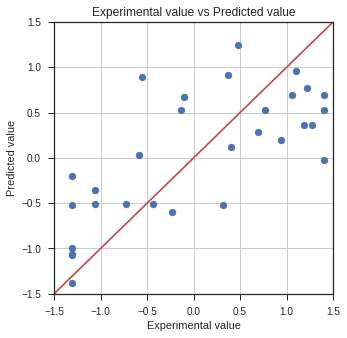

In [29]:
#図の横幅、縦幅を正方形にする
plt.figure(figsize=(5, 5))

#散布図を書く
plt.scatter(y, predicted_value, vmin=0, vmax=10)
plt.title('Experimental value vs Predicted value')
plt.xlabel('Experimental value')
plt.ylabel('Predicted value')
plt.grid(True)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)

#y=xの直線を書く
plt.plot([-1.5, 1.5], [-1.5, 1.5], 'r-')

In [30]:
regr.score(X, y)

0.53913130215933269

決定係数(R<sup>2</sup>)は約0.54であった。

#### 5.1.2 重回帰分析 - 自分で変数を選んでみる

5.1で行なった重回帰分析を自分で変数を選んで行なってみよう。

In [31]:
X2 = descs.loc[:, ['MolWt', 'MolLogP', 'fr_Ar_OH', 'fr_ketone', 'SMR_VSA10', 'fr_halogen', 'NumRotatableBonds']]
X2.head()

,MolWt,MolLogP,fr_Ar_OH,fr_ketone,SMR_VSA10,fr_halogen,NumRotatableBonds
0,1.009496,-1.551973,-0.322004,0.636245,1.714759,-0.179605,2.002495
1,-0.821608,0.471091,-0.322004,-1.829203,-1.734311,-0.179605,-1.050489
2,-0.875905,0.386248,-0.322004,-1.829203,-1.734311,-0.179605,-1.050489
3,-0.984500,0.828408,-0.322004,0.636245,0.500294,-0.179605,-1.050489
4,-0.875905,0.692171,-0.322004,-0.596479,-0.617008,-0.179605,-1.050489


自分で選んだ説明変数と目的変数を含めたデータフレームの相関行列を計算する。

In [32]:
pd.concat([X2, pd.DataFrame(y, columns=['activity'])], axis=1).corr()

,MolWt,MolLogP,fr_Ar_OH,fr_ketone,SMR_VSA10,fr_halogen,NumRotatableBonds,activity
MolWt,1.000000,-0.691603,-0.411515,0.640335,0.705664,0.357471,0.922842,0.628273
MolLogP,-0.691603,1.000000,0.009991,-0.266340,-0.343207,-0.234036,-0.664348,-0.350909
fr_Ar_OH,-0.411515,0.009991,1.000000,-0.471920,-0.453147,-0.059761,-0.349537,-0.426950
fr_ketone,0.640335,-0.266340,-0.471920,1.000000,0.956584,0.118082,0.648830,0.686900
SMR_VSA10,0.705664,-0.343207,-0.453147,0.956584,1.000000,0.092851,0.746124,0.660085
fr_halogen,0.357471,-0.234036,-0.059761,0.118082,0.092851,1.000000,0.182777,-0.101224
NumRotatableBonds,0.922842,-0.664348,-0.349537,0.648830,0.746124,0.182777,1.000000,0.698475
activity,0.628273,-0.350909,-0.426950,0.686900,0.660085,-0.101224,0.698475,1.000000


In [33]:
regr2 = LinearRegression()
regr2.fit(X2, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [34]:
regr2.coef_

array([-0.01302405,  0.04092129, -0.09067271,  1.28049419, -1.12689027,
       -0.28308294,  0.7792503 ])

切片は`intercept_`に保存されている。

In [35]:
regr2.intercept_

-6.0313836576243078e-16

予測値は`predict`メソッドを用いて求めることができる。

In [36]:
predicted_value2 = regr2.predict(X2)
predicted_value2

array([ 0.44619112, -1.09648135, -1.09924606, -0.44090173, -0.76730918,
        1.06232576,  1.01825353,  1.3474257 , -0.7700739 ,  1.11265955,
        0.73941515, -0.76730918, -1.39729891, -1.4476327 , -1.06812675,
       -0.76730918,  0.04073868, -0.00333355,  0.36991085,  0.31957706,
       -0.7700739 ,  1.00922726,  0.52173877,  0.64874923,  1.06232576,
       -0.78210448,  0.27550483,  0.37567987,  0.35788026,  1.02402256,
       -0.55442506])

実測値(実験値)は`y`に保存されている。

In [37]:
y

array([-0.10089286, -1.30435279, -1.30435279, -0.58641696, -0.72755768,
        1.40649011,  1.40649011,  0.47590225, -1.30435279,  1.1919562 ,
        1.40649011, -0.4396306 , -1.30435279, -1.30435279, -1.30435279,
       -1.06441355, -1.06441355, -1.30435279,  0.93508008,  1.27381782,
        0.31782463,  1.05928392,  1.09786239,  0.36957623,  0.76571121,
       -0.22791951, -0.13100288,  0.69043615,  0.40533189,  1.22488904,
       -0.55442506])

続けて実測値と予測値の散布図を書いてみる。

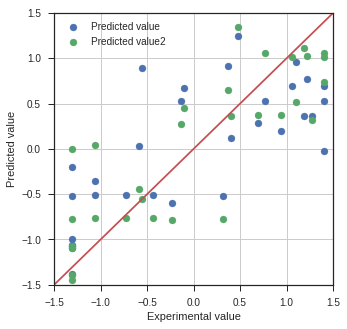

In [38]:
#図の横幅、縦幅を正方形にする
plt.figure(figsize=(5, 5))

#散布図を書く
plt.scatter(y, predicted_value, vmin=0, vmax=10)
plt.scatter(y, predicted_value2, vmin=0, vmax=10)
plt.xlabel('Experimental value')
plt.ylabel('Predicted value')
plt.grid(True)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)

#レジェンドを書く
plt.legend(['Predicted value', 'Predicted value2'])

#y=xの直線を書く
plt.plot([-1.5, 1.5], [-1.5, 1.5], 'r-')

In [39]:
regr2.score(X2, y)

0.71305418783987884

自身で説明変数を選んだり増やしたりすることでR<sup>2</sup>はよくなっただろうか？

#### 5.2.1 Partial Least Square Regression

Partial Least Square Regression (PLSR) を行なってみる。

In [40]:
plsr = PLSRegression(n_components=10)
plsr.fit(descs, y)

PLSRegression(copy=True, max_iter=500, n_components=10, scale=True, tol=1e-06)

In [41]:
plsr.coef_[:5]

array([[-0.18556246],
       [ 0.15552309],
       [-0.18556246],
       [ 0.11679833],
       [ 0.08077896]])

各説明変数の重みを図にしてみる。

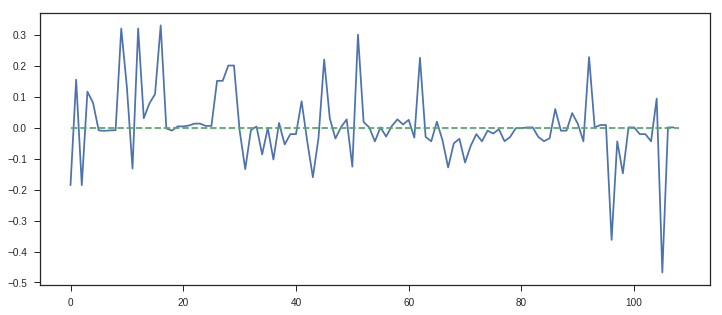

In [42]:
#図の大きさを横長にする
plt.figure(figsize=(12, 5))

#各説明変数の重みを図にする。横軸がn番目の説明変数、縦軸がその説明変数の重みを表している。
plt.plot(range(0, 108), plsr.coef_, linestyle='solid')

#重み=0な水平な線を書く
plt.plot([-0, 108], [0, 0], linestyle='dashed')

予測値は`predict`メソッドを用いて求めることができる。

In [43]:
plsr_predicted_value = plsr.predict(descs)
plsr_predicted_value[:5]

array([[-0.03650745],
       [-1.41710397],
       [-1.47702508],
       [-0.39337825],
       [-0.75330856]])

実測値(実験値)は`y`に保存されている。

In [44]:
y

array([-0.10089286, -1.30435279, -1.30435279, -0.58641696, -0.72755768,
        1.40649011,  1.40649011,  0.47590225, -1.30435279,  1.1919562 ,
        1.40649011, -0.4396306 , -1.30435279, -1.30435279, -1.30435279,
       -1.06441355, -1.06441355, -1.30435279,  0.93508008,  1.27381782,
        0.31782463,  1.05928392,  1.09786239,  0.36957623,  0.76571121,
       -0.22791951, -0.13100288,  0.69043615,  0.40533189,  1.22488904,
       -0.55442506])

続けて実測値と予測値の散布図を書いてみる。

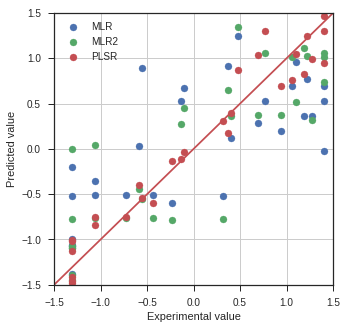

In [45]:
#図の横幅、縦幅を正方形にする
plt.figure(figsize=(5, 5))

#散布図を書く
plt.scatter(y, predicted_value, vmin=0, vmax=10)
plt.scatter(y, predicted_value2, vmin=0, vmax=10)
plt.scatter(y, plsr_predicted_value, vmin=0, vmax=10)
plt.xlabel('Experimental value')
plt.ylabel('Predicted value')
plt.grid(True)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)

#レジェンドを書く
plt.legend(['MLR', 'MLR2', 'PLSR'])

#y=xの直線を書く
plt.plot([-1.5, 1.5], [-1.5, 1.5], 'r-')

In [46]:
plsr.score(descs, y)

0.94068852088906973

決定係数(R<sup>2</sup>)は約0.74と重回帰分析よりも高い値になった。

#### 5.3 3-fold cross validationによるモデルの評価

#### 5.3.1 Training set, Validation setの作成

[kFold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold)を使うことでfoldを作成し、Training setとValidation setに分割することができる。  
再現性を担保せずに分割したい場合はrandom_state=None, shuffle=Trueとする。  
今回はk=3すなわち3-fold cross validationでPLSRを行なってみたい。

In [47]:
k_fold = KFold(n_splits=3, random_state=0, shuffle=True)
print(k_fold)
for train_index, validation_index in k_fold.split(X):
        print("TRAIN:", train_index, "VALIDATION:", validation_index)

KFold(n_splits=3, random_state=0, shuffle=True)
TRAIN: [ 0  1  3  4  6  7  8  9 12 14 15 16 18 19 20 21 24 26 28 30] VALIDATION: [ 2  5 10 11 13 17 22 23 25 27 29]
TRAIN: [ 0  2  3  5  7  9 10 11 12 13 15 17 19 21 22 23 25 26 27 28 29] VALIDATION: [ 1  4  6  8 14 16 18 20 24 30]
TRAIN: [ 1  2  4  5  6  8 10 11 13 14 16 17 18 20 22 23 24 25 27 29 30] VALIDATION: [ 0  3  7  9 12 15 19 21 26 28]


本来はまとめて3回モデルを構築するということを行ったほうが効率的なのだが  
今回はより理解するために、あえてGroup1, Group2をTraining set, Group3をValidation setとしてモデルを構築する作業のみを行なってみる。  
まとめて３回モデルを構築する方法は[5.3.4](#5.3.4-3-fold-cross-validationをまとめて行う)にまとめておく。

`TRAIN: [ 0  1  3  4  6  7  8  9 12 14 15 16 18 19 20 21 24 26 28 30] VALIDATION: [ 2  5 10 11 13 17 22 23 25 27 29]`  

training setとして選ばれた説明変数を変数X_train、目的変数を変数y_trainに代入する。

In [48]:
X_train = descs.loc[[0, 1, 3, 4, 6, 7, 8, 9, 12, 14, 15, 16, 18, 19, 20, 21, 24, 26, 28, 30], :]
X_train.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,MaxPartialCharge,...,fr_allylic_oxid,fr_aryl_methyl,fr_benzene,fr_ester,fr_ether,fr_halogen,fr_ketone,fr_ketone_Topliss,fr_phenol,fr_phenol_noOrthoHbond
0,0.052249,-0.394060,0.052249,-0.558107,0.464983,1.009496,1.079454,1.009584,0.912786,0.145284,...,0.169021,-0.322004,-0.322004,-0.179605,-0.179605,-0.179605,0.636245,0.258342,-0.322004,-0.322004
1,-1.542554,0.732122,-1.542554,-0.535215,-0.318030,-0.821608,-0.933544,-0.821556,-0.635771,-2.292436,...,-1.140890,-0.322004,-0.322004,-0.179605,-0.179605,-0.179605,-1.829203,-1.743812,-0.322004,-0.322004
3,0.108834,0.774114,0.108834,-0.779583,-1.225677,-0.984500,-0.933544,-0.984503,-1.058105,-0.010978,...,0.169021,-0.322004,-0.322004,-0.179605,-0.179605,-0.179605,0.636245,0.258342,-0.322004,-0.322004
4,0.128996,0.731293,0.128996,-0.971518,0.103326,-0.875905,-0.933544,-0.875872,-0.776549,-0.408225,...,-1.140890,-0.322004,-0.322004,-0.179605,-0.179605,-0.179605,-0.596479,0.258342,-0.322004,-0.322004
6,0.115211,-1.426802,0.115211,-0.065769,-0.701379,1.063793,1.079454,1.063900,1.053564,0.810914,...,0.169021,-0.322004,-0.322004,-0.179605,-0.179605,-0.179605,0.636245,0.258342,-0.322004,-0.322004


In [49]:
y_train = y[[0, 1, 3, 4, 6, 7, 8, 9, 12, 14, 15, 16, 18, 19, 20, 21, 24, 26, 28, 30]]
y_train[:5]

array([-0.10089286, -1.30435279, -0.58641696, -0.72755768,  1.40649011])

validation setとして選ばれた説明変数を変数X_validation、目的変数を変数y_validationに代入する。

In [50]:
X_validation = descs.loc[[2, 5, 10, 11, 13, 17, 22, 23, 25, 27, 29]]
X_validation.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,MaxPartialCharge,...,fr_allylic_oxid,fr_aryl_methyl,fr_benzene,fr_ester,fr_ether,fr_halogen,fr_ketone,fr_ketone_Topliss,fr_phenol,fr_phenol_noOrthoHbond
2,-1.556077,0.652810,-1.556077,0.006553,-1.305375,-0.875905,-0.933544,-0.875872,-0.776549,-2.292431,...,0.169021,-0.322004,-0.322004,-0.179605,-0.179605,-0.179605,-1.829203,-1.743812,-0.322004,-0.322004
5,0.052249,0.186266,0.052249,-0.311538,1.693902,0.632890,0.632267,0.632885,0.631230,0.134636,...,0.169021,-0.322004,-0.322004,-0.179605,-0.179605,-0.179605,0.636245,0.258342,-0.322004,-0.322004
10,0.116420,-1.340517,0.116420,-0.012864,-1.257393,0.687187,0.632267,0.687201,0.772008,0.810914,...,1.478932,-0.322004,-0.322004,-0.179605,-0.179605,-0.179605,-0.596479,0.258342,-0.322004,-0.322004
11,-0.321594,0.711672,-0.321594,-0.097519,0.103326,-0.875905,-0.933544,-0.875872,-0.776549,-0.547278,...,-1.140890,-0.322004,-0.322004,-0.179605,-0.179605,-0.179605,-0.596479,0.258342,-0.322004,-0.322004
13,-1.613786,-0.009024,-1.613786,0.668301,-0.888385,-0.931388,-0.822076,-0.931168,-1.058105,-0.961645,...,-1.140890,3.005372,3.005372,-0.179605,-0.179605,-0.179605,-1.829203,-1.743812,3.005372,3.005372


In [51]:
y_validation = y[[2, 5, 10, 11, 13, 17, 22, 23, 25, 27, 29]]
y_validation[:5]

array([-1.30435279,  1.40649011,  1.40649011, -0.4396306 , -1.30435279])

#### 5.3.2 Training setのみかつ主成分数=10でモデルを構築する

Training setのみを用いて[5.2.1](#5.2.1-Partial-Least-Square-Regression)同様にモデルを作る

In [52]:
plsr2 = PLSRegression(n_components=10)
plsr2.fit(X_train, y_train)

PLSRegression(copy=True, max_iter=500, n_components=10, scale=True, tol=1e-06)

予測値は`predict`メソッドを用いて求めることができる。

In [53]:
train_predicted_value = plsr2.predict(X_train)
train_predicted_value[:5]

array([[-0.00928261],
       [-1.36508439],
       [-0.3315187 ],
       [-0.8422503 ],
       [ 1.34581879]])

実測値(実験値)は`y_train`に保存されている。

In [54]:
y_train[:5]

array([-0.10089286, -1.30435279, -0.58641696, -0.72755768,  1.40649011])

続けて実測値と予測値の散布図を書いてみる。

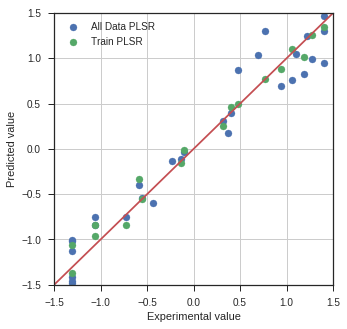

In [55]:
#図の横幅、縦幅を正方形にする
plt.figure(figsize=(5, 5))

#散布図を書く
plt.scatter(y, plsr_predicted_value, vmin=0, vmax=10)
plt.scatter(y_train, train_predicted_value, vmin=0, vmax=10)
plt.xlabel('Experimental value')
plt.ylabel('Predicted value')
plt.grid(True)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)

#レジェンドを書く
plt.legend(['All Data PLSR', 'Train PLSR'])

#y=xの直線を書く
plt.plot([-1.5, 1.5], [-1.5, 1.5], 'r-')

In [56]:
plsr2.score(X_train, y_train)

0.97980170156734525

用いるデータの数が異なるので、All Data PLSRとTraing PLSRはモデル内の各説明変数の重みが変化し、予測値が異なっている。

モデル構築に使わなかったy_validationの値をX_validationから予測してみる。

In [57]:
validation_predicted_value = plsr2.predict(X_validation)
validation_predicted_value[:5]

array([[-2.14033661],
       [ 0.77183817],
       [-0.2092711 ],
       [-0.87662595],
       [-0.78832944]])

y_validationの実測値と予測値の値も含めて再び散布図を書いてみる。

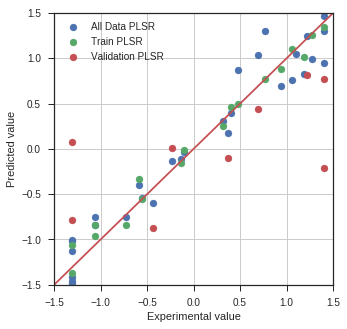

In [58]:
#図の横幅、縦幅を正方形にする
plt.figure(figsize=(5, 5))

#散布図を書く
plt.scatter(y, plsr_predicted_value, vmin=0, vmax=10)
plt.scatter(y_train, train_predicted_value, vmin=0, vmax=10)
plt.scatter(y_validation, validation_predicted_value, vmin=0, vmax=10)
plt.xlabel('Experimental value')
plt.ylabel('Predicted value')
plt.grid(True)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)

#レジェンドを書く
plt.legend(['All Data PLSR', 'Train PLSR', 'Validation PLSR'])

#y=xの直線を書く
plt.plot([-1.5, 1.5], [-1.5, 1.5], 'r-')

In [59]:
plsr2.score(X_validation, y_validation)

-0.20618975351411795

Train PLSRはモデル構築に使ったデータはよく予測できていたが、Validation PLSRをみるとわかるように、  
使ってなかったデータを予測すると大幅に外れていた。これは過学習(オーバーフィッティング)が起きているからだと考えられる。

続けて[5.3.3](#5.3.3-Training-setのみかつ主成分数=3でモデルを構築する)でオーバーフィッティングしないモデルを構築してみよう。

#### 5.3.3 Training setのみかつ主成分数=3でモデルを構築する

主成分数である引数n_componentsを3に減らして[5.3.2](#5.3.2-Training-setのみかつ主成分数=10でモデルを構築する)と同様のことをしてみる。

In [60]:
plsr3 = PLSRegression(n_components=3)
plsr3.fit(X_train, y_train)

PLSRegression(copy=True, max_iter=500, n_components=3, scale=True, tol=1e-06)

予測値は`predict`メソッドを用いて求めることができる。

In [61]:
train_predicted_value2 = plsr3.predict(X_train)
train_predicted_value2[:5]

array([[ 0.68405962],
       [-1.56193033],
       [-0.33061602],
       [-1.01658037],
       [ 0.66267385]])

実測値(実験値)は`y_train`に保存されている。

In [62]:
y_train[:5]

array([-0.10089286, -1.30435279, -0.58641696, -0.72755768,  1.40649011])

続けて実測値と予測値の散布図を書いてみる。

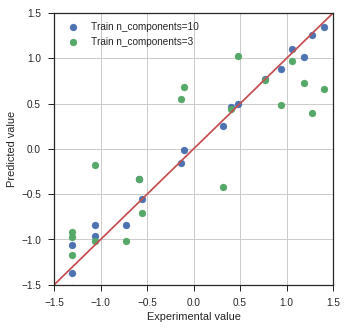

In [63]:
#図の横幅、縦幅を正方形にする
plt.figure(figsize=(5, 5))

#散布図を書く
plt.scatter(y_train, train_predicted_value, vmin=0, vmax=10)
plt.scatter(y_train, train_predicted_value2, vmin=0, vmax=10)
plt.xlabel('Experimental value')
plt.ylabel('Predicted value')
plt.grid(True)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)

#レジェンドを書く
plt.legend(['Train n_components=10', 'Train n_components=3'])

#y=xの直線を書く
plt.plot([-1.5, 1.5], [-1.5, 1.5], 'r-')

In [64]:
plsr3.score(X_train, y_train)

0.72660221176941797

用いる主成分の数が異なるので、`n_components=10`と`n_components=3`ではモデル内の各説明変数の重みが変化し、予測値が異なっている。

モデル構築に使わなかったy_validationの値をX_validationから予測してみる。

In [65]:
validation_predicted_value2 = plsr3.predict(X_validation)
validation_predicted_value2[:5]

array([[-1.27022915],
       [ 0.76528369],
       [ 0.19722634],
       [-0.98791177],
       [-1.30154994]])

y_validationの実測値と予測値の値も含めて再び散布図を書いてみる。

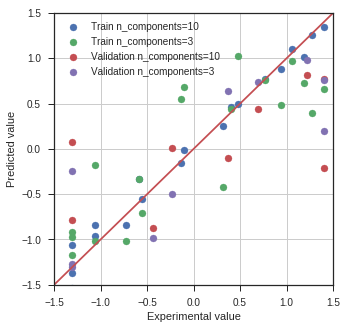

In [66]:
#図の横幅、縦幅を正方形にする
plt.figure(figsize=(5, 5))

#散布図を書く
plt.scatter(y_train, train_predicted_value, vmin=0, vmax=10)
plt.scatter(y_train, train_predicted_value2, vmin=0, vmax=10)
plt.scatter(y_validation, validation_predicted_value, vmin=0, vmax=10)
plt.scatter(y_validation, validation_predicted_value2, vmin=0, vmax=10)
plt.xlabel('Experimental value')
plt.ylabel('Predicted value')
plt.grid(True)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)

#レジェンドを書く
plt.legend(['Train n_components=10', 'Train n_components=3', 'Validation n_components=10', 'Validation n_components=3'])

#y=xの直線を書く
plt.plot([-1.5, 1.5], [-1.5, 1.5], 'r-')

In [67]:
plsr3.score(X_validation, y_validation)

0.68755470732169655

`n_components=3`の場合Training setには劣るものの、Validation setでも良い予測ができておりオーバーフィッティングしてないと言える。

最後に構築したモデルの性能をまとめてみる。

| model | Training r2 | Validation r2 |
|:-------:|:---------------:|:---------------:|
| Multi Linear Regression (All Data) | 0.539 | None |
| Partial Least Square (n_components=10, All Data) | 0.941 | None | 
| Partial Least Square (n_components=10, Group3 for Validation set) | 0.980 | -0.206 |
| Partial Least Square (n_components=3, Group3 for Validation set) | 0.727 | 0.688 |


#### 5.3.4 3-fold cross validationをまとめて行う

[5.3.1](#5.3.1-Training-set,-Validation-setの作成)で前述したように、まとめて3回モデルを構築する方法を最後に行ってみる。  
[cross_val_score](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score)を用いるとkFoldあるいはLeave-one-out cross validationを行いValidation setとした予測値の正答率を求めることができる。

例えば、主成分数`n_components=3`で3-fold cross validationを行いValidation setの決定係数R<sup>2</sup>は以下のように求められる。

In [68]:
plsr4 = PLSRegression(n_components=3)
scores = cross_val_score(plsr4, descs, y, cv=3)
scores

array([ 0.53707127,  0.27622513, -0.65990787])

同様に、主成分数`n_components=10`で3-fold cross validationを行いValidation setの決定係数R<sup>2</sup>は以下のように求められる。

In [69]:
plsr5 = PLSRegression(n_components=10)
scores = cross_val_score(plsr5, descs, y, cv=3)
scores

array([-0.01404196,  0.3236471 , -3.16121242])

これを見ると実は`n_components=3`でもオーバーフィッティングしてしまうモデルが構築されているのがわかる。

以上、簡単ではあるが化学構造を用いた機械学習を行うことができた。情報化学に少しでも興味を持ってもらえたら幸いである。  
機械学習を自身の研究に生かそうと考えていた方がいらっしゃったら、今回学んだことを活かしてどんどん自身の研究などで応用してもらいたい。  